In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle/PreprocessingData"
%cd /content/gdrive/My Drive/Kaggle/PreprocessingData
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle/PreprocessingData
sub.csv		   train_avg_age_upsampling.csv  val_knn_age.csv
test_avg_age.csv   train_knn_age.csv		 XGB_001.sav
test_knn_age.csv   train_knn_age_upsampling.csv
train_avg_age.csv  val_avg_age.csv


In [ ]:
#importing neccessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_train = pd.read_csv('train_knn_age.csv')
df_test = pd.read_csv('test_knn_age.csv')
df_val = pd.read_csv('val_knn_age.csv')
df_train.shape, df_test.shape, df_val.shape

((170760, 14), (62096, 14), (42691, 14))

In [ ]:
y = df_train.country_destination
X = df_train.drop(['country_destination'], axis=1)

In [ ]:
xgb = XGBClassifier(max_depth=10, learning_rate=0.2, n_estimators=100,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=43)
xgb.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=43,
              silent=None, subsample=0.5, verbosity=1)

In [ ]:
import pickle
filename = 'XGB_001.sav'
pickle.dump(xgb, open(filename, 'wb'))

In [ ]:
y_val = df_val.country_destination
X_val = df_val.drop(['country_destination'], axis=1)

In [ ]:
y_pred = xgb.predict_proba(X_val)

In [ ]:
y_pred

array([[5.3846389e-02, 9.5991539e-03, 6.2203226e-03, ..., 5.1532965e-03,
        1.0649428e-03, 2.4994741e-01],
       [4.0345732e-02, 1.3230099e-02, 2.1183651e-03, ..., 2.0244671e-03,
        8.0759926e-03, 6.0015798e-01],
       [5.3747244e-02, 2.3201650e-02, 2.5354496e-03, ..., 2.0256242e-02,
        1.3788326e-03, 3.0408582e-01],
       ...,
       [1.5209399e-02, 3.4735696e-03, 2.3275327e-04, ..., 1.1470456e-03,
        5.8012479e-04, 9.4094664e-01],
       [7.4964084e-02, 1.1478592e-02, 1.0966795e-02, ..., 2.5317142e-02,
        1.0177856e-02, 3.5238910e-01],
       [2.5532128e-02, 9.9963769e-03, 7.3628116e-04, ..., 3.6722678e-03,
        1.1260950e-03, 7.8771591e-01]], dtype=float32)

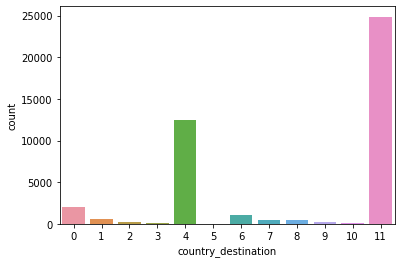

In [ ]:
sns.countplot(y_val)

In [ ]:
from sklearn.metrics import ndcg_score, dcg_score
import math

def NDCG_Score(y_val, y_pred):
  NDCG_score = 0.0
  for i in range(len(y_val)):
    res = y_val[i]
    array_prob = np.argsort(y_pred[i])[-5:][::-1]
    index = np.where(array_prob == res)
    
    if index[0].size != 0:
      DCG[0][index[0][0]] = 1
      NDCG_score += 1.0/math.log(index[0][0]+2, 2)
  NDCG_score = NDCG_score*1.0/len(y_val)
  return NDCG_score

In [ ]:
print(NDCG_Score(y_val, y_pred))

0.8215124119681628


In [ ]:
df_test

,affiliate_channel,affiliate_provider,age,dac_month,first_affiliate_tracked,first_browser,first_device_type,gender,language,signup_app,signup_flow,signup_method,tfa_month,id
0,2.0,4.0,35.0,7,6.0,30.0,8.0,1.0,6.0,1.0,0.0,1.0,7,5uwns89zht
1,2.0,4.0,-1.0,7,6.0,30.0,8.0,0.0,6.0,1.0,0.0,0.0,7,jtl0dijy2j
2,2.0,4.0,-1.0,7,0.0,8.0,6.0,0.0,6.0,2.0,0.0,0.0,7,xx0ulgorjt
3,2.0,4.0,-1.0,7,0.0,22.0,6.0,0.0,6.0,2.0,0.0,0.0,7,6c6puo6ix0
4,2.0,4.0,-1.0,7,6.0,43.0,3.0,0.0,6.0,2.0,0.0,0.0,7,czqhjk3yfe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62091,2.0,4.0,31.0,9,6.0,22.0,6.0,0.0,6.0,2.0,0.0,0.0,9,cv0na2lf5a
62092,2.0,4.0,-1.0,9,6.0,0.0,0.0,0.0,16.0,0.0,15.0,0.0,9,zp8xfonng8
62093,2.0,4.0,-1.0,9,0.0,17.0,6.0,0.0,4.0,2.0,0.0,0.0,9,fa6260ziny
62094,5.0,8.0,-1.0,9,3.0,43.0,3.0,0.0,6.0,2.0,0.0,0.0,9,87k0fy4ugm


In [ ]:
t = {'3':'AU',
  '9':'CA',
  '2':'DE',
  '8':'ES',
  '6':'FR',
  '7':'GB',
  '1':'IT',
  '11':'NDF',
  '10':'NL',
  '5':'PT',
  '4':'US',
  '0':'other'}

In [ ]:
id_test = df_test.id
X_test = df_test.drop(['id'], axis=1)
y_pred = xgb.predict_proba(X_test)
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += (np.argsort(y_pred[i])[::-1])[:5].tolist()

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.country = sub.country.map(t)
sub.to_csv('sub.csv',index=False)

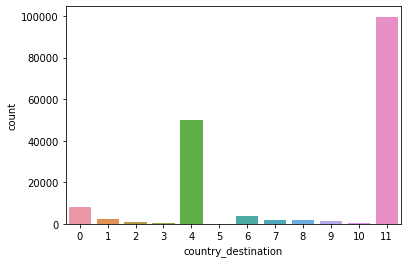

In [ ]:
sns.countplot(df_train.country_destination)